In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import scipy
import corner
import pymc3 as pm
import theano
import theano.tensor as T
from theano.ifelse import ifelse
import seaborn as sns
import os
import sys
sys.path.append("../")
from codebase.data_preprocessing_ogle import process_data
from codebase.plotting_utils import plot_data, plot_emcee_traceplots
import celerite
from celerite.modeling import Model # an abstract class implementing the 
# skeleton of the celerite modeling protocol
from celerite import terms
from scipy.special import gamma
from scipy.stats import invgamma
from scipy.optimize import fsolve

In [2]:
def compute_gradient(t, pars):
    pars = DeltaF, Fb, t0, teff, tE

    u0 = teff/tE
    u = np.sqrt(u0**2 + ((t - t0)/tE)**2)
    A_u = (u**2 + 2)/(u*np.sqrt(u**2 + 4))  
    A_u0 = (u0**2 + 2)/(u0*np.sqrt(u0**2 + 4))  
    dAdu = -8./(u**2*(u**2 + 4)**(3/2.))
    dAdu0 = -8./(u0**2*(u0**2 + 4)**(3/2.))

    # dF/dDeltaF
    dF_dDeltaF = (A_u - 1)/(A_u0 - 1) 

    # dF/dFb
    dF_dFb = np.ones_like(t)

    # dF/dt0
    dF_dt0 = DeltaF/(A_u0 - 1)*dAdu*\
        (-(t - t0)/(u*tE**2))

    # dF/dteff
    dF_dteff = DeltaF*((dAdu/(u*tE))/(A_u0 - 1) - (A_u - 1)/\
        (A_u0 - 1)**2*dAdu0/tE)

    # dF/dtE
    dF_dtE = DeltaF*((-dAdu*((t - t0)**2/(u*tE**3)))\
    /(A_u0 - 1) - (A_u - 1)/(A_u0 - 1)**2*dAdu0*(teff/tE**2))

    gradients = np.array([dF_dDeltaF, dF_dFb, dF_dt0, dF_dteff, dF_dtE])

    return gradients
       
def forward_model(t, pars):
        DeltaF, Fb, t0, teff, tE = pars
        
        u0 = teff/tE

        u = np.sqrt(u0**2 + ((t - t0)/tE)**2)
        A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))

        return DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb

Loaded events: ['blg-0001']


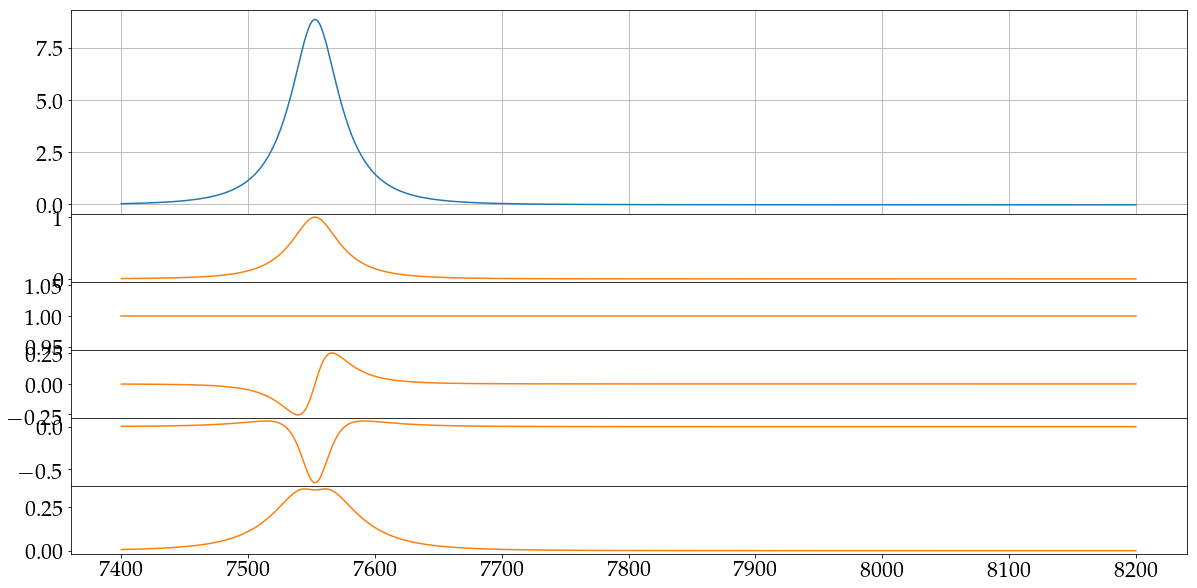

In [32]:
events = [] # event names
lightcurves = [] # data for each event
 
i = 0
n_events = 1
for entry in os.scandir('/home/star/fb90/data/OGLE_ews/2017/'):
    if entry.is_dir() and (i < n_events):
        events.append(entry.name)
        photometry = np.genfromtxt(entry.path + '/phot.dat', usecols=(0,1,2))
        lightcurves.append(photometry)
        i = i + 1
        
print("Loaded events:", events)


DeltaF = np.random.normal(10., 4)
Fb = np.random.normal(0., 0.1)
t0 = np.random.normal(7700., 300.)
teff = np.random.normal(15., 5.)
tE = np.random.normal(40., 20.)

pars = (DeltaF, Fb, t0, teff, tE)

t_ = np.linspace(7400, 8200, 1000)

gradients = compute_gradient(t_, pars)

fig, ax = plt.subplots(6, 1, figsize=(20, 10), gridspec_kw = {'height_ratios':[3, 1, 1, 1, 1, 1]}, sharex=True)

fig.subplots_adjust(hspace=0.0)

ax[0].plot(t_, forward_model(t_, pars), color='C0')
ax[0].grid(True)

for i in range(5):
    ax[i + 1].plot(t_, gradients[i, :], color='C1')
#     ax[i + 1].grid(True)
    